In this brief tutorial, we show you how to train a pySCN classifier, assess its performance, and use it to annotate independent data.

### Data

#### Training data
We will use “10k PBMCs from a Healthy Donor (v3 chemistry) Single Cell Gene Expression Dataset by Cell Ranger 3.0.0” data set from 10X Genomics. [link to processed training data](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/notebook_data/adPBMC_ref_040623.h5ad)

#### Query data sets

1. 20k Human PBMCs, 3’ HT v3.1, Chromium X
  - [download h5ad here](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/notebook_data/adPBMC_query_1_20k_HT_040723.h5ad)

2. [3k human PBMCs from 10x as provided via Scanpy]
  - Data will be loaded via Scanpy's `datasets.pbmc3k()` function

Import requisite packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn

/opt/homebrew/Caskroom/miniforge/base/envs/scnpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the data

In [2]:
adRef = sc.read_h5ad("data/adPBMC_ref_040623.h5ad")
adQuery = sc.read_h5ad("data/adPBMC_query_1_20k_HT_040723.h5ad")
adQ2 = sc.datasets.pbmc3k()

Limit to common genes

In [3]:
cn.ut.limit_anndata_to_common_genes([adRef, adQuery, adQ2])

In [4]:
adRef.obs['cell_type'].value_counts()

cell_type
CD4 T cell         3554
CD14 monocyte      3128
B cell             1450
CD8 T cell         1029
NK cell             608
FCGR3A monocyte     327
Dendritic           154
Megakaryocyte        59
Name: count, dtype: int64

Set aside some cells for training and some held out cells for assessment. Note that we will not be able to properly assess megakaryocytes

In [5]:
n_cells = 100
groupby = 'cell_type'
tids, vids = cn.ut.split_adata_indices(adRef, n_cells, groupby=groupby, cellid=None)
adTrain = adRef[tids].copy()
adHO = adRef[vids].copy()

Do some pre-processing in preparation for classifier training

In [6]:
adTrain.layers['counts'] = adTrain.X.copy()
sc.pp.normalize_total(adTrain)
sc.pp.log1p(adTrain)
sc.pp.highly_variable_genes(adTrain, n_top_genes=2000, flavor='seurat_v3', layer='counts')

Train the classifier

In [7]:
n_rand = n_cells
nTopGenes = 30
nTopGenePairs = 40
n_comps = 30

clf = cn.cl.train_classifier(adTrain, groupby, nRand = n_rand, nTopGenes = nTopGenes, nTopGenePairs = nTopGenePairs, n_comps = n_comps)

Training classifier |████████████████████████████████████████| 5/5 [100%] in 1.6s (3.18/s) 


Classify the held out cells

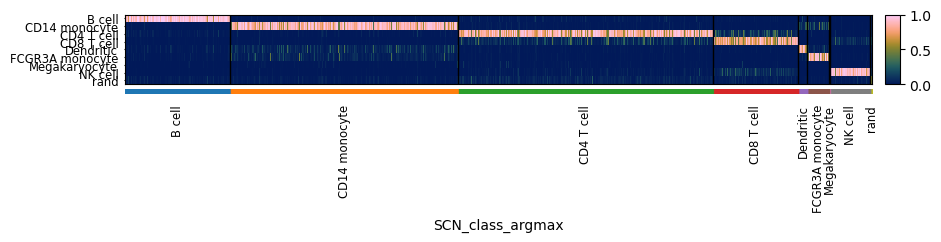

In [8]:
cn.cl.classify_anndata(adHO, clf, nrand = 0)
cn.pl.heatmap_scores(adHO, groupby='SCN_class_argmax')

Assess performance

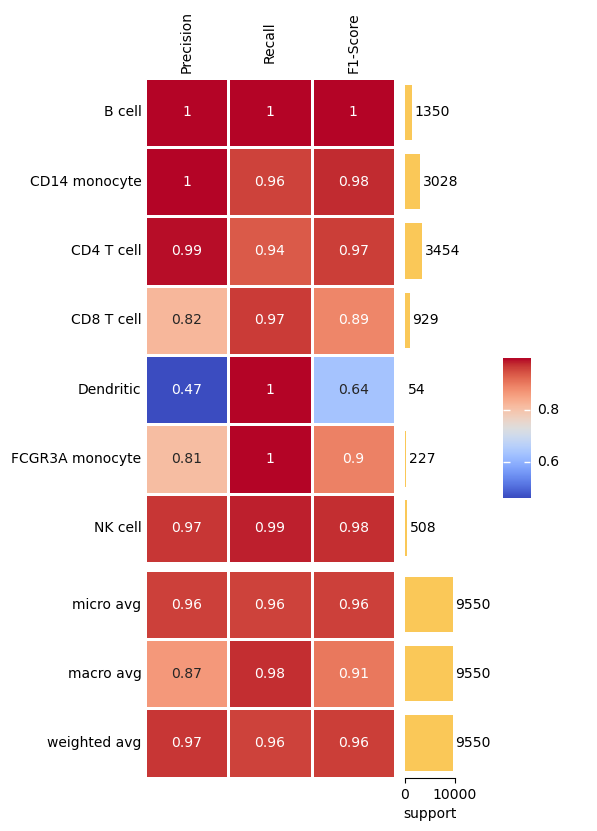

In [9]:
obs_pred="SCN_class_argmax"
c_report = cn.cl.create_classifier_report(adHO, ground_truth=groupby, prediction=obs_pred)
cn.pl.heatmap_classifier_report(c_report)
plt.show()

Classify query data sets

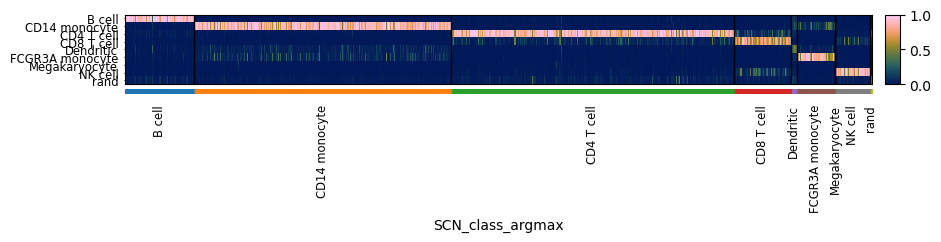

In [10]:
for adx in [adQuery, adQ2]:
    cn.cl.classify_anndata(adx, clf)

cn.pl.heatmap_scores(adQuery, groupby='SCN_class_argmax')

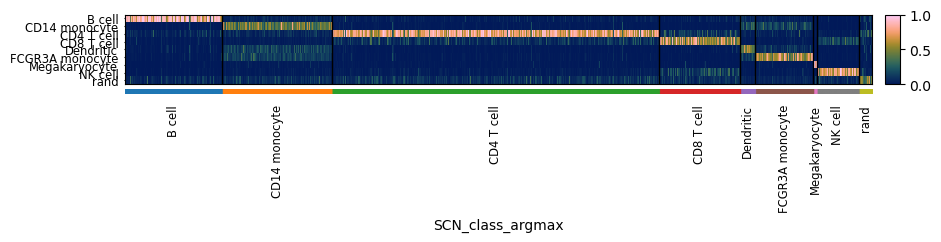

In [11]:
cn.pl.heatmap_scores(adQ2, groupby='SCN_class_argmax')

Plot the proportion of cell types across samples

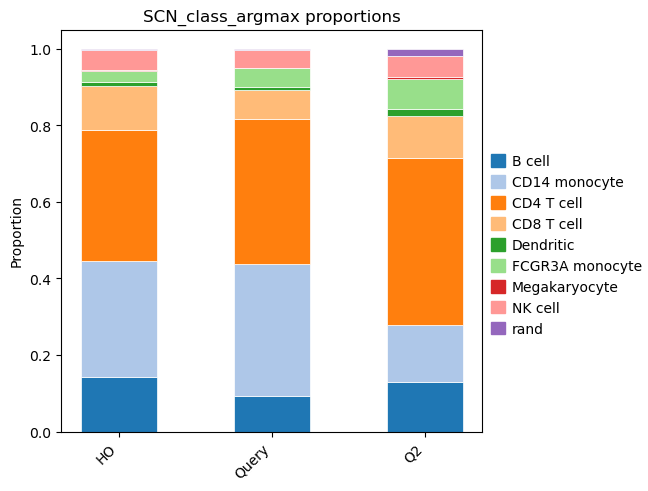

In [12]:
adlist = [adHO, adQuery, adQ2]
adlabels = ["HO", "Query", "Q2"]
afig = cn.pl.stackedbar_composition_list(adlist, labels=adlabels, color_dict=clf['ctColors'], obs_column = 'SCN_class_argmax', bar_width=.5)
plt.show()

UMAP embedding of query data + classification

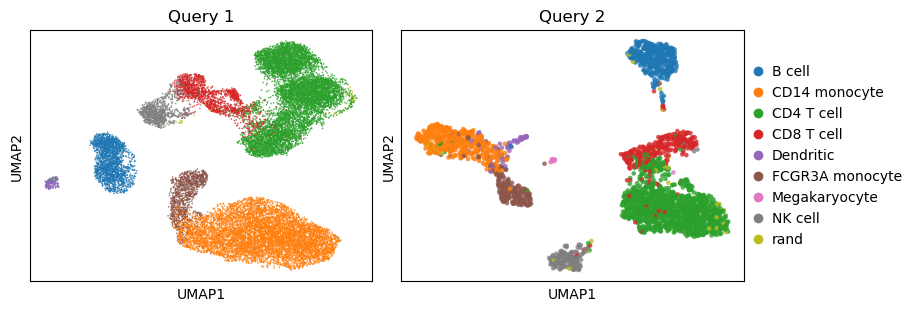

In [13]:
def_npcs = 15
def_nneigh = 10

for adx in [adQuery, adQ2]:
    adx.layers['counts'] = adx.X.copy()
    sc.pp.normalize_total(adx)
    sc.pp.log1p(adx)
    sc.pp.highly_variable_genes(adx, n_top_genes=2000, flavor='seurat_v3', layer='counts')
    sc.tl.pca(adx, mask_var='highly_variable')
    sc.pp.neighbors(adx, n_neighbors = def_nneigh,  n_pcs = def_npcs)
    sc.tl.umap(adx)


fig, axs = plt.subplots(1, 2, figsize=(9, 3), constrained_layout=True)
sc.pl.umap(adQuery, color=['SCN_class_argmax'], alpha=.8, legend_loc=None, show=False, ax=axs[0], title="Query 1")
sc.pl.umap(adQ2, color=['SCN_class_argmax'], alpha=.8, ax=axs[1], title="Query 2")

We can also calculate an embedding based on a combination of the SCN scores and top PCs as follows.

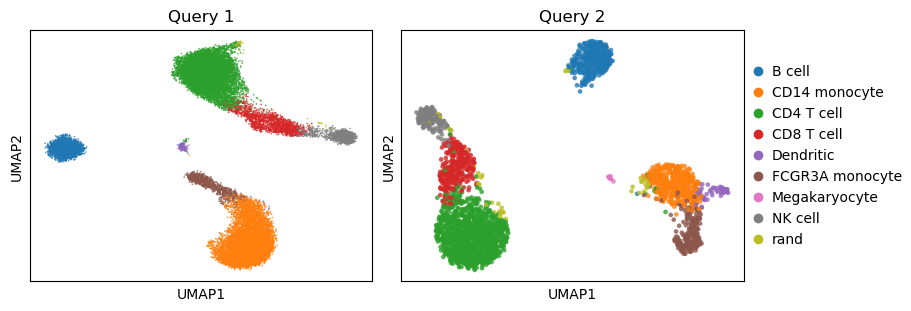

In [14]:
for adx in [adQuery, adQ2]:
    sc.pp.neighbors(adx, n_neighbors = def_nneigh,  use_rep = 'SCN_score', key_added='SCN_score_NN')
    cn.ut.generate_joint_graph(adx, connectivity_keys = ["connectivities", "SCN_score_NN_connectivities"], weights=[0.5, 0.5], output_key='jointNN')
    sc.tl.umap(adx, neighbors_key='jointNN')

fig, axs = plt.subplots(1, 2, figsize=(9, 3), constrained_layout=True)
sc.pl.umap(adQuery, color=['SCN_class_argmax'], alpha=.8, legend_loc=None, show=False, ax=axs[0], title="Query 1")
sc.pl.umap(adQ2, color=['SCN_class_argmax'], alpha=.8, ax=axs[1], title="Query 2")